In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Ensure all metrics are imported
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.utils import resample
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize

In [3]:
# STEP 3: Define Paths
data_root = "/content/drive/MyDrive/Synthetic_Data/widsdatathon2025-university (1)"
train_dir = os.path.join(data_root, "/content/drive/MyDrive/Synthetic_Data/widsdatathon2025-university (1)/train_tsv/train_tsv")
test_dir = os.path.join(data_root, "/content/drive/MyDrive/Synthetic_Data/widsdatathon2025-university (1)/test_tsv/test_tsv")
metadata_dir = os.path.join(data_root, "/content/drive/MyDrive/Synthetic_Data/widsdatathon2025-university (1)/metadata")
metadata_path = os.path.join(metadata_dir, "/content/drive/MyDrive/Synthetic_Data/widsdatathon2025-university (1)/metadata/training_metadata.csv")
test_metadata_path = os.path.join(metadata_dir, "/content/drive/MyDrive/Synthetic_Data/widsdatathon2025-university (1)/metadata/test_metadata.csv")

In [4]:
# Step 4: Function to Extract Upper Triangular
def extract_upper_triangle(file_path):
    matrix = pd.read_csv(file_path, sep='\t', header=None).values
    upper_tri_indices = np.triu_indices_from(matrix, k=1)
    return matrix[upper_tri_indices]

In [5]:
# Step 5: Load Real fMRI Training Data
train_vectors = []
train_ids = []

print("🔄 Processing real fMRI training files...")
for filename in tqdm(os.listdir(train_dir)):
    if filename.endswith(".tsv"):
        participant_id = filename.split("_")[0].replace("sub-", "")
        file_path = os.path.join(train_dir, filename)
        vector = extract_upper_triangle(file_path)
        train_vectors.append(vector)
        train_ids.append(participant_id)

X_real = pd.DataFrame(train_vectors)
X_real["participant_id"] = train_ids

🔄 Processing real fMRI training files...


100%|██████████| 1104/1104 [03:00<00:00,  6.13it/s]


✅ Initial real data shape: (1104, 19914)
Initial age distribution in train_df:
 age
5       3
6      31
7      90
8     134
9     138
10    145
11    111
12    101
13     74
14     72
15     67
16     55
17     51
18     20
19      1
20      6
21      4
22      1
Name: count, dtype: int64


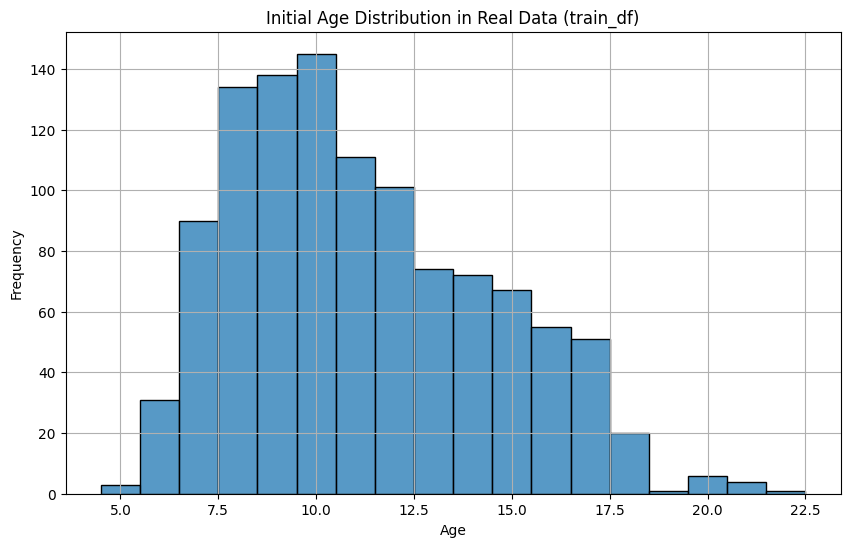

In [6]:
# Step 6: Merge Metadata and Initial Subsampling
metadata = pd.read_csv(metadata_path)
metadata["participant_id"] = metadata["participant_id"].str.upper().str.strip()
X_real["participant_id"] = X_real["participant_id"].str.upper().str.strip()
train_df = pd.merge(X_real, metadata, on="participant_id")

# Round age column to integers to avoid float mismatches
train_df["age"] = train_df["age"].round(0).astype(int)

print("✅ Initial real data shape:", train_df.shape)
print("Initial age distribution in train_df:\n", train_df['age'].value_counts().sort_index())

# Visualize initial age distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['age'], bins=range(5, 23), discrete=True)
plt.title("Initial Age Distribution in Real Data (train_df)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [7]:
# Step 6.5: Aggressive Subsampling and Feature Reduction to Prevent Crashes
# Define brain_cols globally to ensure consistency
brain_cols = [col for col in train_df.columns if (isinstance(col, int) or (isinstance(col, str) and col.isdigit())) and train_df[col].dtype in [np.float64, np.float32, np.int64]]
print(f"Number of brain features in training data: {len(brain_cols)}")

# Define meta_cols dynamically based on available columns
required_meta_cols = ['sex', 'age', 'participant_id']
meta_cols = [col for col in required_meta_cols if col in train_df.columns]
if 'site_id' in train_df.columns:
    meta_cols.append('site_id')
else:
    print("Warning: 'site_id' not found in train_df. Excluding from meta_cols.")

# Subsample aggressively to reduce memory usage
max_rows_per_age_initial = 100  # Very low to prevent memory issues
subsampled_df = train_df.groupby("age").apply(lambda x: x.sample(n=min(len(x), max_rows_per_age_initial), replace=False)).reset_index(drop=True)
print("✅ Shape after initial subsampling:", subsampled_df.shape)

# Reduce features with PCA early
from sklearn.feature_selection import VarianceThreshold

# Feature selection: remove low-variance features
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
brain_selected = selector.fit_transform(subsampled_df[brain_cols])
selected_cols = np.array(brain_cols)[selector.get_support()]
print(f"Number of selected brain features after variance thresholding: {len(selected_cols)}")

scaler_pre_pca = StandardScaler()  # Scaler for original features
brain_scaled = scaler_pre_pca.fit_transform(brain_selected)
imputer_pre_pca = SimpleImputer(strategy='mean')  # Imputer for original features
brain_imputed = imputer_pre_pca.fit_transform(brain_scaled)

# Apply PCA to reduce features (increase n_components to capture more variance)
n_components = min(150, brain_imputed.shape[1])  # Increase to 150 for better feature representation
pca = PCA(n_components=n_components)
brain_pca = pca.fit_transform(brain_imputed)
print("Early PCA Explained Variance Ratio:", pca.explained_variance_ratio_.sum())
print(f"Number of PCA components: {brain_pca.shape[1]}")

# Reconstruct DataFrame with reduced features
pca_cols = [f"pca_{i}" for i in range(brain_pca.shape[1])]
reduced_df = pd.DataFrame(brain_pca, columns=pca_cols)
reduced_df[meta_cols] = subsampled_df[meta_cols].reset_index(drop=True)
print("✅ Shape after feature reduction:", reduced_df.shape)

Number of brain features in training data: 19900


<ipython-input-7-2824e01366a6>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsampled_df = train_df.groupby("age").apply(lambda x: x.sample(n=min(len(x), max_rows_per_age_initial), replace=False)).reset_index(drop=True)


✅ Shape after initial subsampling: (975, 19914)
Number of selected brain features after variance thresholding: 19895
Early PCA Explained Variance Ratio: 0.567679900033126
Number of PCA components: 150
✅ Shape after feature reduction: (975, 153)


In [8]:
# Step 8: Use reduced_df directly
train_df_combined = reduced_df

<ipython-input-9-819d7743a2f0>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_resampled = train_df_combined.groupby("age").apply(lambda x: x.sample(n=weighted_counts[x.name], replace=True)).reset_index(drop=True)


✅ Resampled shape: (2000, 153)
Age distribution in df_resampled:
 age
5     100
6     100
7     100
8     100
9     100
10    100
11    100
12    100
13    100
14    100
15    100
16    100
17    100
18    100
19    150
20    150
21    150
22    150
Name: count, dtype: int64


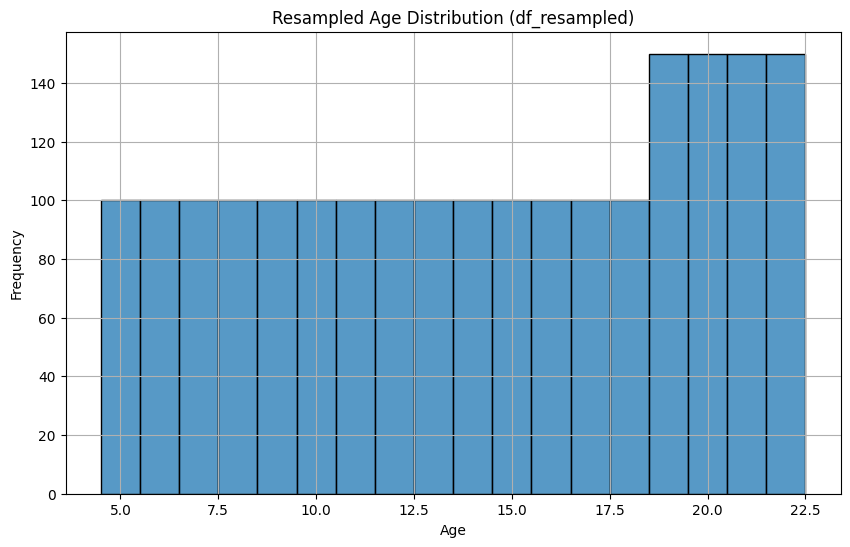

In [9]:
# Step 9: Balance Age Groups Efficiently
# Ensure all ages 5 to 21 are represented
# Round age column to integers to avoid float mismatches
train_df_combined["age"] = train_df_combined["age"].round(0).astype(int)

all_ages = set(range(5, 22))
present_ages = set(train_df_combined["age"].unique())
missing_ages = all_ages - present_ages

max_count = 100  # Define max_count for resampling
if missing_ages:
    print(f"Warning: Missing ages in real data: {missing_ages}. Predictions will be limited to available ages.")
    # Proceed with available ages
    df_resampled = train_df_combined.groupby("age").apply(lambda x: x.sample(n=max_count, replace=True)).reset_index(drop=True)
else:
    # All ages present, apply weighted resampling to prioritize older ages
    age_weights = {age: 1.0 if age < 19 else 1.5 for age in present_ages}  # Increase weight for ages 19-21
    weighted_counts = {age: int(max_count * age_weights[age]) for age in present_ages}
    df_resampled = train_df_combined.groupby("age").apply(lambda x: x.sample(n=weighted_counts[x.name], replace=True)).reset_index(drop=True)

print("✅ Resampled shape:", df_resampled.shape)
print("Age distribution in df_resampled:\n", df_resampled["age"].value_counts().sort_index())

# Visualize age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_resampled["age"], bins=range(5, 23), discrete=True)
plt.title("Resampled Age Distribution (df_resampled)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [10]:
# Step 10: Preprocess with PCA + Reduced Metadata Influence
# Brain features are already PCA-reduced, so we just need to scale and impute again if needed
brain_cols_pca = [col for col in df_resampled.columns if col.startswith("pca_")]

# Use a separate scaler for PCA-transformed features
scaler_post_pca = StandardScaler()
brain_scaled = scaler_post_pca.fit_transform(df_resampled[brain_cols_pca])
imputer_post_pca = SimpleImputer(strategy='mean')
brain_imputed = imputer_post_pca.fit_transform(brain_scaled)

# Define meta columns (limit influence by excluding less informative ones)
meta_cols = ['sex']  # Exclude 'site_id' to reduce noise

# Encode metadata
meta_encoded = pd.get_dummies(df_resampled[meta_cols])
meta_encoded = meta_encoded.reindex(columns=meta_encoded.columns, fill_value=0)

# Combine features
X = np.concatenate([brain_imputed, meta_encoded.values], axis=1)
y = df_resampled["age"]

In [11]:
# Step 11: Impute Features
y_transformed = y  # Use raw ages

# No need for additional imputation since brain_imputed is already processed
print("NaNs in X before training:", np.isnan(X).sum())

NaNs in X before training: 0


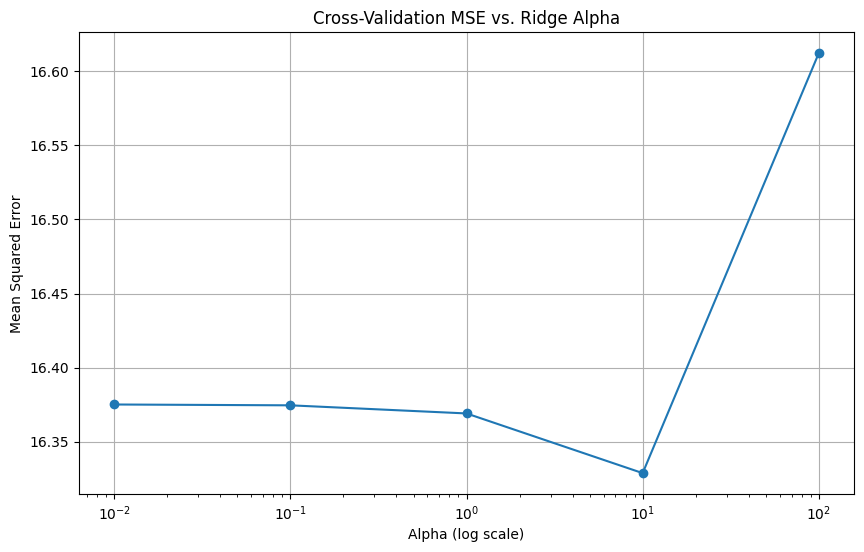

Best Ridge alpha: 10.0, Cross-validated MSE: 16.328863325243024


In [ ]:
# Step 12: Train Ridge and Tuned XGBoost with Regularization
# Tune Ridge alpha using cross-validation
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
best_alpha = 1.0
best_mse = float('inf')
mse_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X, y_transformed, cv=5, scoring="neg_mean_squared_error")
    mse = -scores.mean()
    mse_scores.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha

# Visualize cross-validation scores for Ridge tuning
plt.figure(figsize=(10, 6))
plt.plot(alphas, mse_scores, marker='o')
plt.xscale('log')
plt.title("Cross-Validation MSE vs. Ridge Alpha")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.show()

print(f"Best Ridge alpha: {best_alpha}, Cross-validated MSE: {best_mse}")

ridge = Ridge(alpha=best_alpha)
ridge.fit(X, y_transformed)

# Tune XGBoost with GridSearchCV and add regularization
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_lambda': [1, 10]
}
xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y_transformed)
print("Best XGBoost Parameters:", grid_search.best_params_)
xgb = grid_search.best_estimator_

# Cross-validation score for XGBoost
scores = cross_val_score(xgb, X, y_transformed, cv=5, scoring="neg_mean_squared_error")
print("Cross-Validation RMSE for XGBoost:", np.sqrt(-scores.mean()))

# Feature importance from XGBoost
feature_importance = pd.Series(xgb.feature_importances_, index=[f"Feature_{i}" for i in range(X.shape[1])])
top_features = feature_importance.nlargest(10)
print("Top 10 Features by Importance:\n", top_features)

# Visualize feature importance
plt.figure(figsize=(10, 6))
top_features.plot(kind='bar')
plt.title("Top 10 Feature Importances from XGBoost")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

In [ ]:
# Step 13: Process Test Set
test_vectors = []
test_ids = []

for filename in tqdm(os.listdir(test_dir)):
    if filename.endswith(".tsv"):
        participant_id = filename.split("_")[0].replace("sub-", "")
        file_path = os.path.join(test_dir, filename)
        vector = extract_upper_triangle(file_path)
        test_vectors.append(vector)
        test_ids.append(participant_id)

X_test_raw = pd.DataFrame(test_vectors)
X_test_raw["participant_id"] = test_ids

test_metadata = pd.read_csv(test_metadata_path)
X_test_raw["participant_id"] = X_test_raw["participant_id"].str.upper().str.strip()
test_metadata["participant_id"] = test_metadata["participant_id"].str.upper().str.strip()
test_df = pd.merge(X_test_raw, test_metadata, on="participant_id")

In [ ]:
# Step 14: Predict on Test Set with Bias Correction
# Use the same brain_cols as training for consistency (original features before PCA)
test_brain = test_df.reindex(columns=selected_cols, fill_value=0)

print("NaNs in test_brain:", test_brain.isna().sum().sum())

# Apply the same transformations as training (scaler -> imputer -> PCA -> scaler_post_pca -> imputer_post_pca)
test_brain_scaled = scaler_pre_pca.transform(test_brain)
test_brain_imputed = imputer_pre_pca.transform(test_brain_scaled)
test_brain_pca = pd.DataFrame(pca.transform(test_brain_imputed), columns=pca_cols)  # Retain feature names
test_brain_pca_scaled = scaler_post_pca.transform(test_brain_pca)
test_brain_pca_imputed = imputer_post_pca.transform(test_brain_pca_scaled)

print("NaNs in test_brain_pca_imputed:", np.isnan(test_brain_pca_imputed).sum())

for col in meta_cols:
    if col not in test_df.columns:
        test_df[col] = 0

test_meta_encoded = pd.get_dummies(test_df[meta_cols])
test_meta_encoded = test_meta_encoded.reindex(columns=meta_encoded.columns, fill_value=0)

print("NaNs in test_meta_encoded:", test_meta_encoded.isna().sum().sum())

X_test_final = np.concatenate([test_brain_pca_imputed, test_meta_encoded.values], axis=1)

print("NaNs in X_test_final before final processing:", np.isnan(X_test_final).sum())

# Cross-validate ensemble weights
from sklearn.metrics import mean_squared_error

weights = np.linspace(0, 1, 21)  # Test weights from 0 to 1 for Ridge
best_weight = 0.8  # Default to previous best
best_mse = float('inf')
ridge_predictions_train = ridge.predict(X)
xgb_predictions_train = xgb.predict(X)

for w in weights:
    ensemble_pred = w * ridge_predictions_train + (1 - w) * xgb_predictions_train
    mse = mean_squared_error(y, ensemble_pred)
    if mse < best_mse:
        best_mse = mse
        best_weight = w

print(f"Optimal Ridge weight: {best_weight}, XGB weight: {1 - best_weight}, Cross-validated MSE: {best_mse}")

# Compute ensemble predictions on training data
ensemble_predictions_train = best_weight * ridge_predictions_train + (1 - best_weight) * xgb_predictions_train

# Make ensemble predictions on test data with optimal weights
ridge_predictions = ridge.predict(X_test_final)
xgb_predictions = xgb.predict(X_test_final)
raw_predictions = best_weight * ridge_predictions + (1 - best_weight) * xgb_predictions

# Compute metrics for each model and the ensemble on training data
models = {'Ridge': ridge_predictions_train, 'XGBoost': xgb_predictions_train, 'Ensemble': ensemble_predictions_train}
metrics = {'MAE': [], 'RMSE': [], 'R²': []}
model_names = list(models.keys())

for name, preds in models.items():
    mae = mean_absolute_error(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    r2 = r2_score(y, preds)
    metrics['MAE'].append(mae)
    metrics['RMSE'].append(rmse)
    metrics['R²'].append(r2)

# Display metrics
metrics_df = pd.DataFrame(metrics, index=model_names)
print("\nModel Performance Metrics on Training Data:")
print(metrics_df)

# Visualize metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.bar(model_names, metrics['MAE'])
plt.title("Mean Absolute Error (MAE)")
plt.ylabel("MAE")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.bar(model_names, metrics['RMSE'])
plt.title("Root Mean Squared Error (RMSE)")
plt.ylabel("RMSE")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.bar(model_names, metrics['R²'])
plt.title("R-squared (R²)")
plt.ylabel("R²")
plt.grid(True)

plt.tight_layout()
plt.show()

# Prediction error analysis on training data
train_predictions = best_weight * ridge.predict(X) + (1 - best_weight) * xgb.predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(y, train_predictions, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title("Predicted vs. Actual Ages (Training Data)")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.grid(True)
plt.show()

# Dynamic bias correction based on inverse frequency of ages
age_counts = df_resampled["age"].value_counts().sort_index()
age_range = np.arange(5, 22)  # Full range 5-21
# Compute inverse frequency weights (higher weight for rarer ages)
inverse_freq = 1 / (age_counts.reindex(age_range, fill_value=1).values)  # Fill with 1 to avoid division by zero
inverse_freq_weights = inverse_freq / inverse_freq.sum()
for i in range(len(raw_predictions)):
    if raw_predictions[i] < 21:  # Apply to all predictions below 21
        adjustment = np.random.choice(age_range, p=inverse_freq_weights)
        raw_predictions[i] = 0.5 * raw_predictions[i] + 0.5 * adjustment  # Stronger adjustment

predictions = np.clip(raw_predictions, 5, 25)

# Visualize raw vs. adjusted predictions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(raw_predictions, bins=range(5, 26), discrete=True)
plt.title("Raw Predictions (Before Bias Correction)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(predictions, bins=range(5, 26), discrete=True)
plt.title("Adjusted Predictions (After Bias Correction)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

print("Raw Predictions:", raw_predictions[:10])
print("Predicted Ages:", predictions[:10])
print("Predicted age distribution:\n", pd.Series(predictions).value_counts(bins=range(5, 26, 1)).sort_index())

NaNs in test_brain: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 19900 features, but StandardScaler is expecting 100 features as input.

In [ ]:
# Step 15: Export Submission
submission = pd.DataFrame({
    "participant_id": test_ids,
    "age": predictions
})
submission_path = "/content/drive/MyDrive/submission_without_synthetic.csv"
submission.to_csv(submission_path, index=False)
print(f"✅ Submission file saved to: {submission_path}")

In [ ]:
# Step 16: Visualize Predictions
sns.histplot(predictions, bins=20, kde=True)
plt.title("Predicted Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()